In [1]:
import os
import sys

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install SmartStockRL package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

    # Clone or update repo.
    repo = "smart-stock-rl"
    repo_url = f"https://github.com/zanderman/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

    # Set dataset root path.
    dataset_root = '~/dataset'

except:
    IN_COLAB = False
    dataset_root = '~/Desktop'
    print('NOT IN COLAB')

# Import package.
import smart_stock as ss

NOT IN COLAB


In [3]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [4]:
# Import other necessary packages after we know that imports are available.
from __future__ import annotations
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

## Dataset

In [5]:
# Request user for Kaggle login if JSON file does not exist.
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) and os.environ.get("KAGGLE_USERNAME",None) is None and os.environ.get("KAGGLE_USERNAME",None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Kaggle Username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:    
        api_key = getpass.getpass(prompt="Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key

    # In Google Colab preserve the login auth across environment restarts.
    if IN_COLAB:
        !mkdir -p ~/.kaggle/
        with open(os.path.expanduser("~/.kaggle/kaggle.json"), 'w') as f:
            json.dump({'username':os.environ["KAGGLE_USERNAME"], 'key':os.environ["KAGGLE_KEY"]}, f)

In [6]:
# Prepare dataset.
stocks = ['aapl', 'nvda', 'dis', 'ko', 'pg']
path = os.path.expanduser(dataset_root)

# This command will download the dataset if it does not exist on the system.
dataset = ss.datasets.HugeStockMarketDataset(path, quiet=False)

## Training Functions

In [7]:
import time
from contextlib import contextmanager

class timecontext:
    """Elapsed time context manager."""
    def __enter__(self):
        self.seconds = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        self.seconds = time.time() - self.seconds

@contextmanager
def timecontextprint(description='Elapsed time'):
    """Context manager to print elapsed time from call."""
    with timecontext() as t:
        yield t
    print(f"{description}: {t.seconds} seconds")

In [8]:
def train(
    agent,
    env: gym.Env,
    max_episodes: int = 1000,
    **kwargs,
    ) -> tuple[list[float], bool]:
    """Generic agent training method.

    Specific methods should wrap this one and pass agent-specific arguments
    as keyword arguments.
    """
    # List of reward values for plotting.
    rewards = []

    # Boolean solution flag.
    found_soln = False

    # Episode loop.
    for i in range(max_episodes):
        reward = agent.run_episode(env=env, **kwargs)
        rewards.append(reward)
        # if i%100 == 0: print(f'[{i}] {reward}')
        print(f'[{i}] {reward}')

    return rewards, found_soln

In [9]:
def train_QSFM(
    agent: ss.algorithms.qlearning.qsfm.QSFM, 
    env: gym.Env,
    max_episodes: int = 1000,
    max_steps: int = None,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train QSFM agent."""
    return train(
        agent=agent,
        env=env,
        max_episodes=max_episodes,
        max_steps=max_steps,
        render=render,
        render_mode=render_mode,
        )

In [10]:
def train_DQN(
    agent: ss.algorithms.deepq.dqn.DQN, 
    env: gym.Env,
    max_episodes: int = 1000,
    max_steps: int = None,
    target_update_freq: int = 10,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train DQN agent."""
    return train(
        agent=agent,
        env=env,
        max_episodes=max_episodes,
        max_steps=max_steps, 
        target_update_freq=target_update_freq,
        render=render, 
        render_mode=render_mode,
        )

## Environment

In [11]:
# Make runs reproduceable.
RANDOM_SEED = 0 # Turn off by setting as `None`
if RANDOM_SEED is not None:
    np.random.seed(RANDOM_SEED)

In [12]:
def build_env(
    stock: str,
    start_balance: float = 10_000,
    max_shares: int = 1,
    start_day: int = None,
    ) -> gym.Env:
    """Create stock environment using specific stock name."""
    env = ss.envs.StockDataEnv(
        df=dataset[stock], 
        start_balance=start_balance, 
        max_shares=max_shares, 
        start_day=start_day,
        name=f'StockDataEnv-{stock.upper()}',
    )

    # Set random seed if one is provided.
    if RANDOM_SEED is not None:
        env.seed(RANDOM_SEED)
        env.action_space.seed(RANDOM_SEED)

    return env

In [13]:
# Create stock environment using specific stock.
start_balance = 10_000
max_shares = 10
start_day = 0
stock_train = 'aapl' # 'voo' # 'aapl'
env = build_env(
    stock=stock_train,
    start_balance=start_balance,
    max_shares=max_shares,
    start_day=start_day,
)

In [14]:
# Make runs reproduceable.
RANDOM_SEED = 0 # Turn off by setting as `None`
if RANDOM_SEED is not None:
    env.seed(RANDOM_SEED)
    env.action_space.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

In [15]:
# Set tweakable parameters.
gamma = 0.9 # Discount factor (should be in (0,1)).
alpha = 0.01 # 0.0001 # Step size.
epsilon = 0.2 # Epsilon-greedy action selection (should be in (0,1)).

# Initialize linear function approximator by clipping low/high observation range.
order = 3
obs_low = np.clip(env.observation_space.low, -10, 10)
obs_high = np.clip(env.observation_space.high, -10, 10)
lfa = ss.mapping.fourier.FourierStateFeatureMapping(obs_low, obs_high, order)

# Create Q-learning algorithm agent with LFA.
agent = ss.algorithms.qlearning.qsfm.QSFM(env, lfa, gamma, alpha, epsilon)

[0] 4.8828125
Elapsed time: 0.09330391883850098 seconds


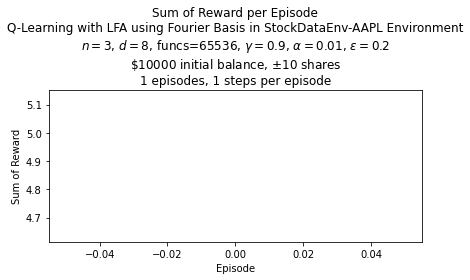

In [16]:
max_episodes = 1 # 100 # 1000 # Upper-limit on number of possible episodes.
max_steps = 1 # 500
render = False
render_mode = 'csv'

# Train the agent 
with timecontextprint():
    rewards, found_soln = train_QSFM(
        agent,
        env,
        max_episodes, 
        max_steps, 
        render, 
        render_mode,
    )

# Plot the rewards.
plt.figure()
plt.plot(rewards)
plt.title(f"Sum of Reward per Episode\nQ-Learning with LFA using Fourier Basis in {env.name} Environment\n$n={order}$, $d={obs_low.size}$, funcs={lfa.coeffs.shape[0]}, $\gamma={gamma}$, $\\alpha={alpha}$, $\epsilon={epsilon}$\n\${env.start_balance} initial balance, $\pm${env.max_shares} shares\n{max_episodes} episodes, {'No max' if max_steps is None else max_steps} steps per episode")
plt.xlabel('Episode')
plt.ylabel('Sum of Reward')
plt.tight_layout()
plt.show()

## Testing

In [17]:
def evaluate(
    agent,
    env: gym.Env,
    ) -> list[tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray]]:
    """Evaluate a DQN agent using the given environment."""

    # Get initial obseration.
    curr_state = env.reset()

    # Run a single episode.
    transitions: list[tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray]] = []
    while True:
        curr_state, action, next_state, reward, done = agent.step(
            env,
            curr_state,
            )
        transitions.append((
            curr_state,
            action,
            next_state,
            reward,
        ))

        curr_state = next_state

        if done:
            break

    return tuple(*zip(*transitions))

In [18]:
def run_evaluation(
    agent,
    stock_name: str,
    start_balance: float,
    max_shares: int,
    start_day: int,
    ) -> plt.Figure:
    """Runs evaluation for the given agent on a given stock."""
    # Define test environment.
    env_test = build_env(
        stock=stock_name,
        start_balance=start_balance,
        max_shares=max_shares,
        start_day=start_day,
    )
    transitions = evaluate(agent, env_test)

    # Unpack transition elements.
    transition_state = np.stack(transitions[0])
    transition_action = np.stack(transitions[1])

    # Get final stats for agent.
    final_balance = transition_state[-1,0]
    final_net_worth = transition_state[-1,1]
    final_shares = int(transition_state[-1,2])
    total_gains = final_net_worth - env_test.start_balance

    # Plot investment history.
    fig = plt.figure(figsize=(20,5))
    ax = plt.gca()
    ax.plot(transition_state[:,6], color='b')
    ax.plot(transition_state[:,6], '^', markersize=10, color='m', label = 'buying signal', markevery=(transition_action>0).nonzero().flatten())
    ax.plot(transition_state[:,6], '.', markersize=10, color='g', label = 'hold signal', markevery=(transition_action==0).nonzero().flatten())
    ax.plot(transition_state[:,6], 'v', markersize=10, color='k', label = 'selling signal', markevery=(transition_action<0).nonzero().flatten())
    ax.set_title(f"Investment History for {stock_name.upper()}\nQ-Learning with LFA using Fourier Basis in {env_test.name} Environment\nBalance=\${final_balance}, Shares={final_shares}, Net Worth=\${final_net_worth}, Total Gains = \${total_gains}")
    ax.set_xlabel('Day')
    ax.set_ylabel('Closing Value')
    ax.legend()
    fig.tight_layout()
    return fig

Show performance on **training set** for baseline.

In [19]:
fig = run_evaluation(
    agent=agent,
    stock_name=stock_train,
    start_balance=start_balance,
    max_shares=max_shares,
    start_day=start_day,
)

Evaluate agent on a stock that it has not seen before. Here we evaluate on the Google stock (`GOOG`) using the same parameters as with the training set.

In [ ]:
stock_test = 'goog'
fig = run_evaluation(
    agent=agent,
    stock_name=stock_test,
    start_balance=start_balance,
    max_shares=max_shares,
    start_day=start_day,
)